In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis/Folds.csv
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/process_db_stat.py
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/fibroadenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/phyllodes_tumor.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/tubular_adenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/adenosis.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/README_B.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides

In [2]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from pathlib import Path

import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim


In [3]:
import cv2
from matplotlib.image import imread

import tensorflow as tf
#from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Num GPUs Available:  0


In [5]:
import glob
import PIL
import random


In [6]:
# ====== ADD THESE NEW IMPORTS ======
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
from tensorflow.keras import layers

# ====== VISION TRANSFORMER IMPLEMENTATION ======
class PatchExtract(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtract, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

class ViTBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(ViTBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.nn.gelu),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs):
        x = self.norm1(inputs)
        x = self.attn(x, x)
        x = self.dropout1(x)
        x = x + inputs
        
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.dropout2(y)
        y = y + x
        return y

class SSLHead(layers.Layer):
    def __init__(self, projection_dim=128, temperature=0.1):
        super(SSLHead, self).__init__()
        self.projection_dim = projection_dim
        self.temperature = temperature
        self.projection = tf.keras.Sequential([
            layers.Dense(projection_dim, activation=None),
            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        ])
    
    def call(self, inputs):
        return self.projection(inputs)
    
    def contrastive_loss(self, z1, z2):
        z1 = tf.math.l2_normalize(z1, axis=1)
        z2 = tf.math.l2_normalize(z2, axis=1)
        sim = tf.matmul(z1, z2, transpose_b=True) / self.temperature
        batch_size = tf.shape(z1)[0]
        pos_mask = tf.eye(batch_size, dtype=tf.float32)
        neg_mask = 1 - pos_mask
        pos = tf.reduce_sum(sim * pos_mask, axis=-1)
        neg = tf.reduce_logsumexp(sim * neg_mask, axis=-1)
        return -tf.reduce_mean(pos - neg)

random.seed(100)

In [7]:
breast_img_paths = glob.glob('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png', recursive = True)
for img_path in breast_img_paths[:5]:
    print(img_path)

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-006.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-004.png


In [8]:
# types of cancer
benign = []
malignant = []
# subtypes
A, F, PT, TA = [], [], [], [] # subtypes for benign
DC, LC, MC, PC = [], [], [], [] # subtypes for malignant

for img in breast_img_paths:
    img_name = Path(img).name
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P'and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)
    elif img_name[6] == 'D':
        DC.append(img)
    elif img_name[6] == 'L':
        LC.append(img)
    elif img_name[6] == 'M':
        MC.append(img)
    elif img_name[6] == 'P':
        PC.append(img)
    if img_name[4] == 'B':
        benign.append(img)
    else:
        malignant.append(img)

In [9]:
print("Total examples: ", len(breast_img_paths))
print("Number of benign examples", len(benign))
print("Number of malignant examples", len(malignant))

Total examples:  7909
Number of benign examples 2480
Number of malignant examples 5429


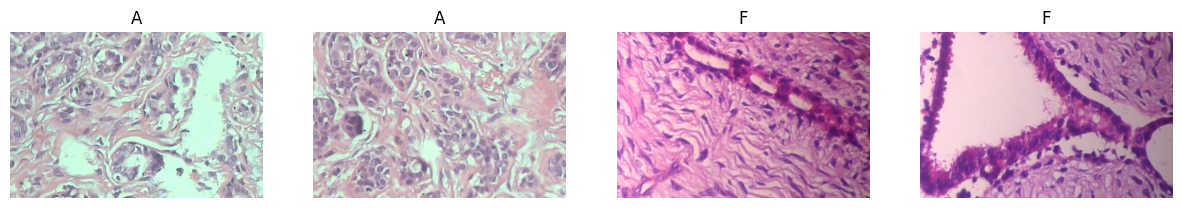

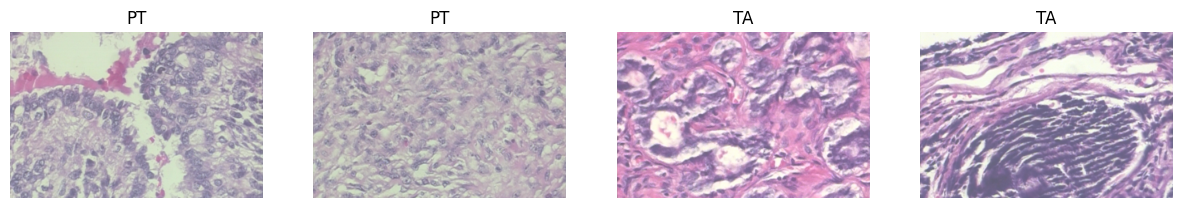

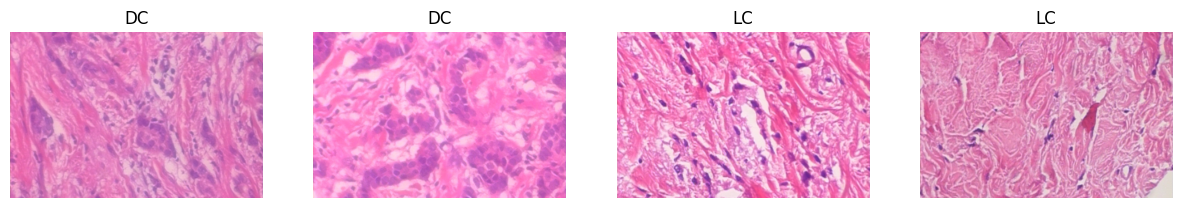

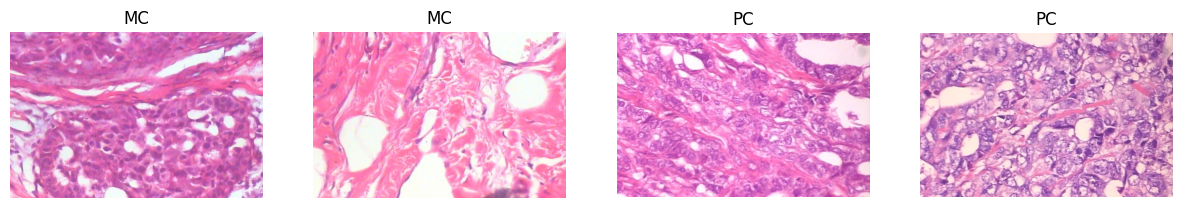

In [10]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)  
        ax.axis('off')
    
    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()

# Display images from each list
display_images("A", "F", A, F)
display_images("PT","TA", PT, TA)
display_images("DC","LC", DC, LC)
display_images("MC","PC", MC, PC)

In [11]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0
        if label != 4:
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array



In [12]:
def augment_image(img):
    augmented_images = []

    augmented_images.append(img)

    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

A_imgs  = load_and_resize_images(A, 0)
F_imgs  = load_and_resize_images(F, 1)
PT_imgs  = load_and_resize_images(PT, 2)
TA_imgs = load_and_resize_images(TA, 3)
DC_imgs = load_and_resize_images(DC, 4)
LC_imgs = load_and_resize_images(LC, 5)
MC_imgs = load_and_resize_images(MC, 6)
PC_imgs = load_and_resize_images(PC, 7)

In [13]:
data_b = A_imgs + F_imgs + PT_imgs + TA_imgs 
data_m = DC_imgs + LC_imgs + MC_imgs + PC_imgs
print("Total number of benign examples:", len(data_b))
print("Total number of malignant examples:", len(data_m))

random.shuffle(data_b)
random.shuffle(data_m)

# Initial split to separate out the test set (20% of the data)
dataTrain_b, dataTest_b = train_test_split(data_b, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_b, dataVal_b = train_test_split(dataTrain_b, test_size=0.25, random_state=42)

# Initial split to separate out the test set (20% of the data)
dataTrain_m, dataTest_m = train_test_split(data_m, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_m, dataVal_m = train_test_split(dataTrain_m, test_size=0.25, random_state=42)

dataTrain_b_modified = [(image, 0) for image, label in dataTrain_b]
dataTrain_m_modified = [(image, 1) for image, label in dataTrain_m]

dataTrain = dataTrain_b_modified + dataTrain_m_modified
random.shuffle(dataTrain)

dataVal_b_modified = [(image, 0) for image, label in dataVal_b]
dataVal_m_modified = [(image, 1) for image, label in dataVal_m]

dataVal = dataVal_b_modified + dataVal_m_modified
random.shuffle(dataVal)

dataTest_b_modified = [(image, 0) for image, label in dataTest_b]
dataTest_m_modified = [(image, 1) for image, label in dataTest_m]

dataTest = dataTest_b_modified + dataTest_m_modified

print("Total number of examples:", len(dataTrain) + len(dataVal) + len(dataTest))

Total number of benign examples: 7440
Total number of malignant examples: 9385
Total number of examples: 16825


In [14]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  # Convert images to numpy array
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

with tf.device('/GPU:0'):
    train_dataset = create_tf_dataset(dataTrain)
    val_dataset = create_tf_dataset(dataVal)
    test_dataset = create_tf_dataset(dataTest)

In [15]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
from tensorflow.keras.applications import InceptionV3

# Define the path where you uploaded the weights
weights_path = "/kaggle/input/h5shit/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load the model with manually uploaded weights and specify input shape
base_model = InceptionV3(
    weights=weights_path, 
    include_top=False, 
    input_shape=(128, 128, 3)  # Explicitly defining the input shape
)

In [17]:
# Extract intermediate layers
layer_names = ['mixed4', 'mixed7', 'mixed10']
intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]
# Create a new model that outputs intermediate layers
intermediate_model = Model(inputs=base_model.input, outputs=intermediate_outputs)

In [18]:
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)
# Concatenate the branch outputs for score-level fusion
fusion = tf.keras.layers.Concatenate()(branch_outputs)

# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(2, activation='softmax')(x)

In [19]:
# Combine everything into a model
binary_model = Model(inputs=base_model.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

binary_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
binary_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,036,306 (84.06 MB)

 Trainable params: 22,001,458 (83.93 MB)

 Non-trainable params: 34,848 (136.12 KB)

In [20]:
import time

start_time = time.time()

history = binary_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=10,
                           callbacks=[early_stopping, reduce_lr])

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 794s 5s/step - accuracy: 0.6504 - loss: 1.0757 - val_accuracy: 0.5634 - val_loss: 1.0214 - learning_rate: 1.0000e-04
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 726s 5s/step - accuracy: 0.8577 - loss: 0.7168 - val_accuracy: 0.7932 - val_loss: 0.8567 - learning_rate: 1.0000e-04
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 722s 5s/step - accuracy: 0.9153 - loss: 0.5866 - val_accuracy: 0.9085 - val_loss: 0.6495 - learning_rate: 1.0000e-04
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 764s 5s/step - accuracy: 0.9601 - loss: 0.4884 - val_accuracy: 0.9162 - val_loss: 0.5534 - learning_rate: 1.0000e-04
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 720s 5s/step - accuracy: 0.9770 - loss: 0.4382 - val_accuracy: 0.9263 - val_loss: 0.5207 - learning_rate: 1.0000e-04
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 720s 5s/step - accuracy: 0.9805 - loss: 0.4098 - val_accuracy: 0.9311 - val_loss: 0.5098 - learning_rate: 1.0000e-04
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 727s 5s/step - acc

In [21]:
train_loss, train_acc = binary_model.evaluate(train_dataset)
print(f"Train accuracy (binary classification): {train_acc}")
test_loss, test_acc = binary_model.evaluate(test_dataset)
print(f"Test accuracy (binary classification): {test_acc}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 132s 838ms/step - accuracy: 0.9972 - loss: 0.2813
Train accuracy (binary classification): 0.9979197382926941
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 849ms/step - accuracy: 0.9462 - loss: 0.4215
Test accuracy (binary classification): 0.9488855600357056


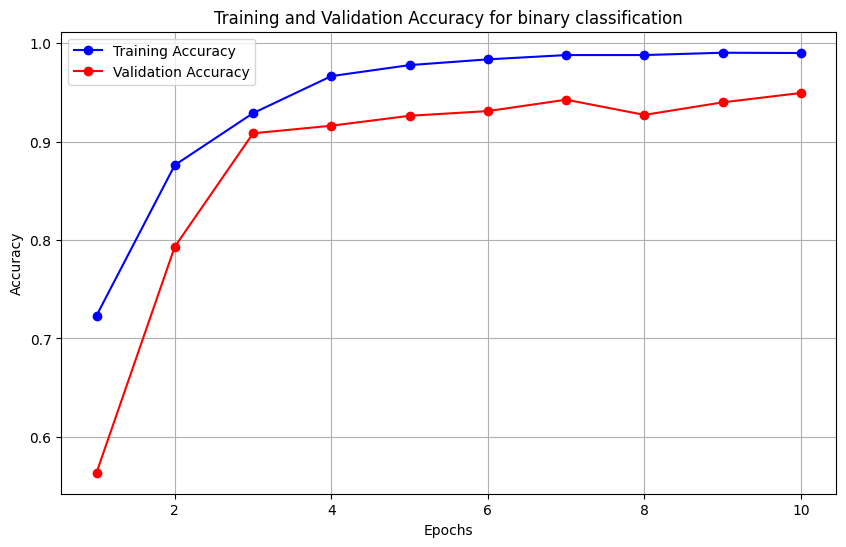

In [22]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for binary classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Predict the classes for each image
    predictions = binary_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1) 
    true_classes = np.argmax(labels, axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute precision, recall, and F1 score for multi-class classification
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9542
Recall: 0.9542
F1 Score: 0.9542


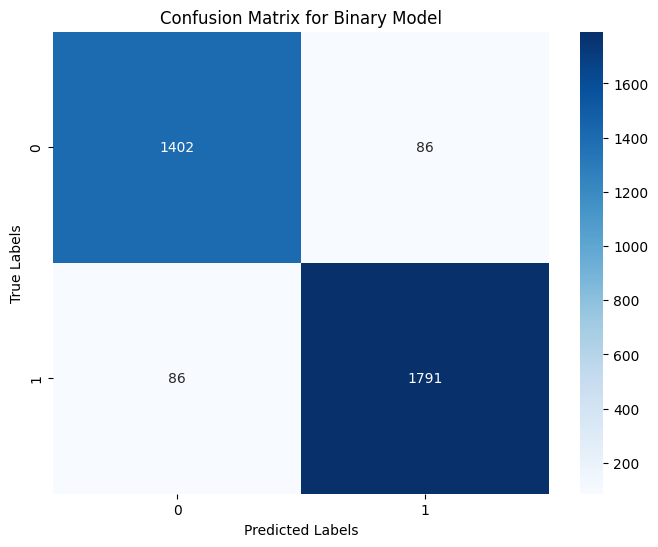

In [24]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Binary Model')
plt.show()

In [25]:
dataTrain_m = [(image, label-4) for image, label in dataTrain_m]
dataVal_m = [(image, label-4) for image, label in dataVal_m]
dataTest_m = [(image, label-4) for image, label in dataTest_m]

In [26]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  # Convert images to numpy array
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

dataTrain_b = create_tf_dataset(dataTrain_b)
dataVal_b = create_tf_dataset(dataVal_b)
test_dataset_b = create_tf_dataset(dataTest_b)
dataTrain_m = create_tf_dataset(dataTrain_m)
dataVal_m = create_tf_dataset(dataVal_m)
test_dataset_m = create_tf_dataset(dataTest_m)

In [27]:
try:
    base_model_b = InceptionV3(
        weights=weights_path,
        include_top=False,
        input_shape=(128, 128, 3)
    )
except Exception:  # Explicit exception type
    base_model_b = InceptionV3(
        weights=None,
        include_top=False,
        input_shape=(128, 128, 3)
    )
# Get intermediate layers
layer_names = ['mixed4', 'mixed7', 'mixed10']
intermediate_outputs = [base_model_b.get_layer(name).output for name in layer_names]
intermediate_model = Model(inputs=base_model_b.input, outputs=intermediate_outputs)

# Define the branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)
# Concatenate the branch outputs for score-level fusion
fusion = tf.keras.layers.Concatenate()(branch_outputs)



In [28]:
# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)

# Combine everything into a model
benign_model = Model(inputs=base_model_b.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

benign_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [29]:
import time

start_time = time.time()

history_b = benign_model.fit(dataTrain_b,
                    validation_data=dataVal_b,
                    epochs=10)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.3484 - loss: 2.1038 - val_accuracy: 0.2507 - val_loss: 1.7568
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - accuracy: 0.5372 - loss: 1.4924 - val_accuracy: 0.3078 - val_loss: 1.7174
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.6563 - loss: 1.2118 - val_accuracy: 0.4469 - val_loss: 1.6485
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - accuracy: 0.7525 - loss: 1.0193 - val_accuracy: 0.5692 - val_loss: 1.5630
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.8009 - loss: 0.9191 - val_accuracy: 0.6720 - val_loss: 1.4483
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.8450 - loss: 0.8357 - val_accuracy: 0.7513 - val_loss: 1.3119
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.8990 - loss: 0.7394 - val_accuracy: 0.7829 - val_loss: 1.1689
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - accuracy: 0.9019 - loss: 0.7183 - val_accuracy: 0.8098 - v

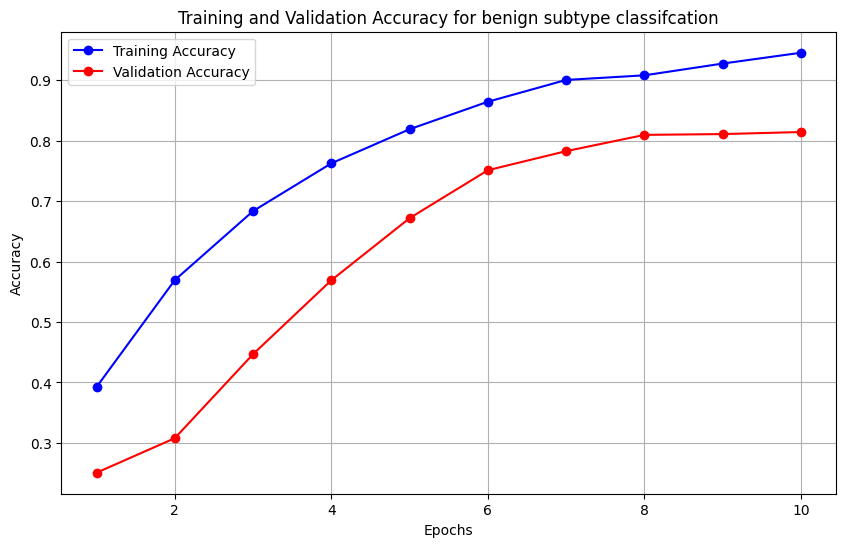

In [30]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history_b.history['accuracy']
val_acc = history_b.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for benign subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true_b = []
y_pred_b = []

for images, labels in test_dataset_b:  
    # Predict the classes for each image
    predictions_b = benign_model.predict(images, verbose=0)
    predicted_classes_b = np.argmax(predictions_b, axis=1) 
    true_classes_b = np.argmax(labels, axis=1) 

    y_true_b.extend(true_classes_b)
    y_pred_b.extend(predicted_classes_b)

y_true_b = np.array(y_true_b)
y_pred_b = np.array(y_pred_b)

precision = precision_score(y_true_b, y_pred_b, average='macro')
recall = recall_score(y_true_b, y_pred_b, average='macro')
f1 = f1_score(y_true_b, y_pred_b, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8022
Recall: 0.8153
F1 Score: 0.8083


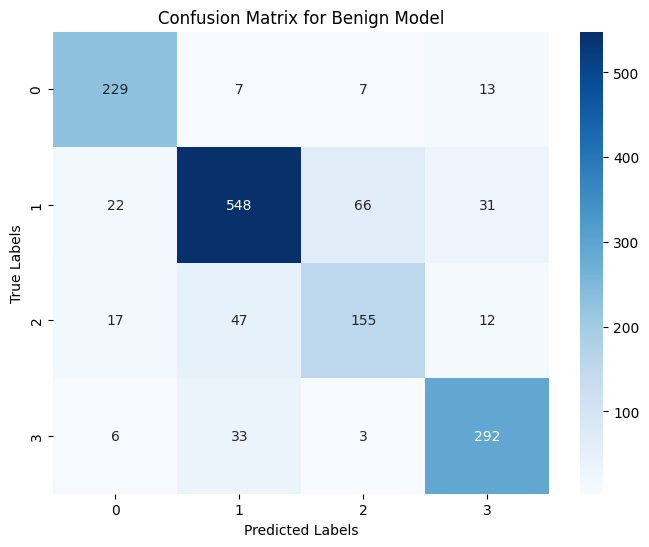

In [32]:
conf_matrix_b = confusion_matrix(y_true_b, y_pred_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Benign Model')
plt.show()